In [ ]:
import cv2
import urllib.request
import os
import time
import numpy as np


In [ ]:
def download_sample_video(save_path="sample_video.mp4"):
    """
    Downloads a public sample video automatically (pedestrians or traffic).
    Tries multiple sources to avoid 404 errors.
    """
    urls = [
        # Free-to-use public sample videos (small size)
        "https://videos.pexels.com/video-files/854143/854143-hd_1920_1080_25fps.mp4",  # pedestrians
        "https://videos.pexels.com/video-files/855869/855869-hd_1920_1080_25fps.mp4",  # cars on the street
        "https://github.com/opencv/opencv/raw/master/samples/data/vtest.avi",          # OpenCV classic test video
    ]

    if os.path.exists(save_path):
        print(f"Video already exists: {save_path}")
        return save_path

    for url in urls:
        try:
            print(f"Attempting to download sample video from:\n{url}")
            urllib.request.urlretrieve(url, save_path)
            print("Download successful!")
            return save_path
        except Exception as e:
            print(f" Failed: {e}")
            continue

    raise RuntimeError("All video sources failed. Please provide your own video file.")

# Run downloader
video_path = download_sample_video()


Video already exists: sample_video.mp4


In [3]:
def create_tracker(name):
    """
    Creates an OpenCV tracker instance by name.
    Supported: KCF, CSRT, MOSSE
    """
    name = name.upper()
    if name == "KCF":
        return cv2.TrackerKCF_create()
    elif name == "CSRT":
        return cv2.TrackerCSRT_create()
    elif name == "MOSSE":
        return cv2.legacy.TrackerMOSSE_create()
    else:
        raise ValueError(f"Unknown tracker name: {name}")


In [4]:
def initialize_tracker(video_path, tracker_name="KCF"):
    """
    Loads video, selects ROI, and initializes tracker.
    """
    video = cv2.VideoCapture(video_path)
    ok, frame = video.read()
    if not ok:
        raise RuntimeError("Could not read video file")

    print("Select the object to track and press ENTER or SPACE.")
    bbox = cv2.selectROI("Select Object", frame, fromCenter=False, showCrosshair=True)
    cv2.destroyWindow("Select Object")

    tracker = create_tracker(tracker_name)
    tracker.init(frame, bbox)
    print(f"{tracker_name} tracker initialized.")
    return video, tracker, frame, bbox


In [ ]:
def run_tracking(video, tracker, first_frame, bbox, tracker_name="KCF"):
    """
    Safe tracking function for Jupyter.
    Supports: [1] KCF, [2] CSRT, [3] MOSSE
    Press [r] to reselect ROI
    Press [ESC] to quit
    """
    current_tracker_name = tracker_name
    fps_list = []
    print("\nControls:\n[1] KCF  [2] CSRT  [3] MOSSE  [r] Reselect ROI  [ESC] Exit\n")

    while True:
        ok, frame = video.read()
        if not ok or frame is None:
            print("End of video or invalid frame. Exiting...")
            break

        start_time = time.time()
        try:
            ok, bbox = tracker.update(frame)
        except cv2.error:
            print(f"Tracker {current_tracker_name} failed internally. Restarting tracker.")
            ok = False

        elapsed = time.time() - start_time
        fps = 1.0 / max(elapsed, 1e-3)  # avoid zero-div & unrealistic FPS
        fps = min(fps, 60)  # cap at 60 FPS for display
        fps_list.append(fps)

        # Draw bounding box
        if ok:
            (x, y, w, h) = [int(v) for v in bbox]
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            status = f"{current_tracker_name} Tracking"
        else:
            status = f"{current_tracker_name} LOST"
            cv2.putText(frame, "Tracking Lost!", (50, 80),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        # Display info
        avg_fps = np.mean(fps_list[-10:]) if fps_list else 0
        cv2.putText(frame, f"Tracker: {current_tracker_name}", (20, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        cv2.putText(frame, f"FPS: {avg_fps:.1f}", (20, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

        cv2.imshow("Object Tracking (1=KCF, 2=CSRT, 3=MOSSE, r=ROI)", frame)
        key = cv2.waitKey(1) & 0xFF

        # === Keyboard Commands ===
        if key == 27:  # ESC
            break
        elif key == ord('r'):  # reselect ROI
            print("🔁 Reselecting ROI...")
            new_bbox = cv2.selectROI("Select Object", frame, fromCenter=False, showCrosshair=True)
            cv2.destroyWindow("Select Object")
            bbox = new_bbox
            tracker = create_tracker(current_tracker_name)
            tracker.init(frame, bbox)
        elif key in [ord('1'), ord('2'), ord('3')]:
            # Switch trackers safely
            if key == ord('1'):
                current_tracker_name = "KCF"
            elif key == ord('2'):
                current_tracker_name = "CSRT"
            elif key == ord('3'):
                current_tracker_name = "MOSSE"

            print(f"Switching to {current_tracker_name} tracker...")
            tracker = create_tracker(current_tracker_name)
            tracker.init(frame, bbox)

    video.release()
    cv2.destroyAllWindows()

    avg_fps_total = np.mean(fps_list) if fps_list else 0
    print(f"\nAverage FPS ({current_tracker_name}): {avg_fps_total:.1f}")


In [6]:
# Initialize and run the demo
video, tracker, frame, bbox = initialize_tracker(video_path, "CSRT")
run_tracking(video, tracker, frame, bbox, "KCF")


Select the object to track and press ENTER or SPACE.
CSRT tracker initialized.

Controls:
[1] KCF  [2] CSRT  [3] MOSSE  [r] Reselect ROI  [ESC] Exit

Switching to CSRT tracker...
Switching to MOSSE tracker...
End of video or invalid frame. Exiting...

Average FPS (MOSSE): 52.3


In [8]:

import pandas as pd

def run_tracking_and_log(video_path, tracker_name="KCF", output_path="output_tracking.mp4"):
    """
    Runs one tracker (KCF / CSRT / MOSSE), saves output video, 
    and logs FPS and success rate.
    """
    video = cv2.VideoCapture(video_path)
    ok, frame = video.read()
    if not ok:
        raise RuntimeError("Could not read video file.")

    # Select ROI
    print(f"Select ROI for {tracker_name} tracker:")
    bbox = cv2.selectROI("Select Object", frame, fromCenter=False, showCrosshair=True)
    cv2.destroyWindow("Select Object")

    # Initialize tracker
    tracker = create_tracker(tracker_name)
    tracker.init(frame, bbox)

    # Set up video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps_video = video.get(cv2.CAP_PROP_FPS) or 20.0
    out = cv2.VideoWriter(output_path, fourcc, fps_video, (frame.shape[1], frame.shape[0]))

    fps_list = []
    success_count = 0
    frame_count = 0

    while True:
        ok, frame = video.read()
        if not ok:
            break
        frame_count += 1

        start = time.time()
        try:
            success, bbox = tracker.update(frame)
        except cv2.error:
            success = False

        elapsed = time.time() - start
        fps = 1.0 / max(elapsed, 1e-3)
        fps = min(fps, 60)
        fps_list.append(fps)

        # Draw box
        if success:
            success_count += 1
            (x, y, w, h) = [int(v) for v in bbox]
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            label = f"{tracker_name} Tracking"
        else:
            label = f"{tracker_name} LOST"
            cv2.putText(frame, "Tracking Lost!", (50, 80),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        avg_fps = np.mean(fps_list[-10:]) if fps_list else 0
        cv2.putText(frame, f"Tracker: {tracker_name}", (20, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        cv2.putText(frame, f"FPS: {avg_fps:.1f}", (20, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

        out.write(frame)
        cv2.imshow(f"{tracker_name} Tracking", frame)

        if cv2.waitKey(1) & 0xFF == 27:  # ESC
            break

    video.release()
    out.release()
    cv2.destroyAllWindows()

    # Metrics
    avg_fps_total = np.mean(fps_list) if fps_list else 0
    success_rate = (success_count / frame_count) * 100 if frame_count > 0 else 0

    print(f"\n{tracker_name} Results:")
    print(f"  Avg FPS: {avg_fps_total:.2f}")
    print(f"  Success Rate: {success_rate:.1f}% ({success_count}/{frame_count} frames)")
    print(f"  Output saved as: {output_path}")

    return {
        "Tracker": tracker_name,
        "Average FPS": round(avg_fps_total, 2),
        "Success Rate (%)": round(success_rate, 1),
        "Frames Tracked": success_count,
        "Total Frames": frame_count
    }


In [9]:
results = []

for tracker_name in ["KCF", "CSRT", "MOSSE"]:
    result = run_tracking_and_log(video_path, tracker_name, f"{tracker_name}_output.mp4")
    results.append(result)

df_results = pd.DataFrame(results)
df_results


Select ROI for KCF tracker:

KCF Results:
  Avg FPS: 59.91
  Success Rate: 0.8% (3/373 frames)
  Output saved as: KCF_output.mp4
Select ROI for CSRT tracker:

CSRT Results:
  Avg FPS: 46.06
  Success Rate: 35.3% (212/601 frames)
  Output saved as: CSRT_output.mp4
Select ROI for MOSSE tracker:

MOSSE Results:
  Avg FPS: 60.00
  Success Rate: 66.0% (524/794 frames)
  Output saved as: MOSSE_output.mp4


,Tracker,Average FPS,Success Rate (%),Frames Tracked,Total Frames
0,KCF,59.91,0.8,3,373
1,CSRT,46.06,35.3,212,601
2,MOSSE,60.00,66.0,524,794


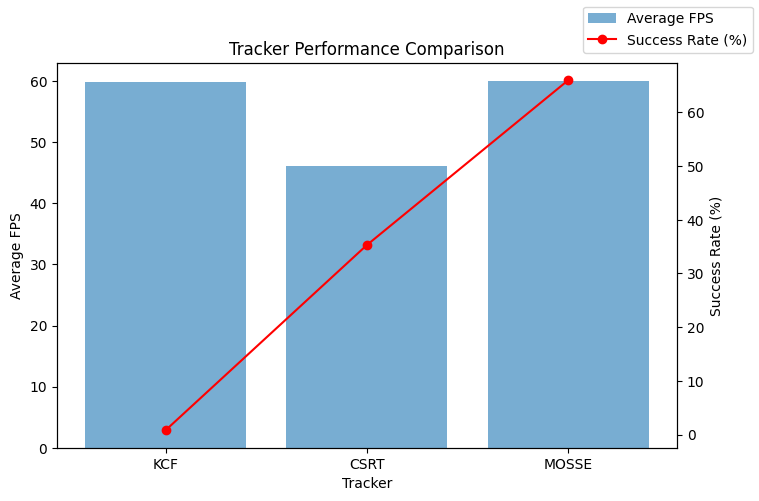

In [10]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.bar(df_results["Tracker"], df_results["Average FPS"], alpha=0.6, label="Average FPS")
ax1.set_ylabel("Average FPS")
ax1.set_xlabel("Tracker")
ax1.set_title("Tracker Performance Comparison")

# Overlay success rate
ax2 = ax1.twinx()
ax2.plot(df_results["Tracker"], df_results["Success Rate (%)"], 'o-', color='red', label="Success Rate (%)")
ax2.set_ylabel("Success Rate (%)")

fig.legend(loc="upper right")
plt.show()


In [12]:
df_results.sort_values(by="Average FPS", ascending=False).style.background_gradient(subset=["Average FPS"], cmap="Blues")


,Tracker,Average FPS,Success Rate (%),Frames Tracked,Total Frames
2,MOSSE,60.000000,66.000000,524,794
0,KCF,59.910000,0.800000,3,373
1,CSRT,46.060000,35.300000,212,601
